<a href="https://colab.research.google.com/github/NaziaHasanDana/DeepLearning/blob/main/VGG_16_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile

# Path to your zip file
zip_path = '/content/covid-19_healthy.zip'

# Directory where you want to extract the files
extract_dir = '/content/covid-19_healthy'

# Create the target directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to: {extract_dir}")


Dataset extracted to: /content/covid-19_healthy


In [2]:
# List the files in the extracted directory
!ls /content/covid-19_healthy


covid-19  healthy  pneumonia


In [3]:
# Libraries
import os
import pathlib

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

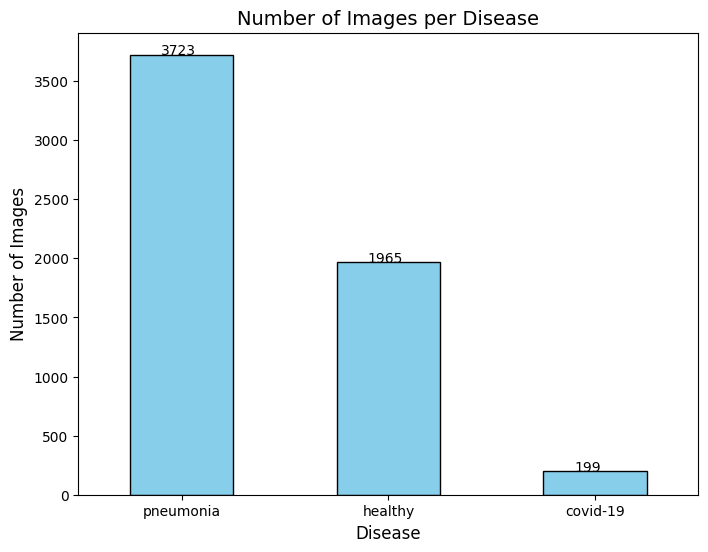

Training set size = 4709, Validation set size = 589, Test set size = 589


In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Path to the unzipped dataset in Google Colab
data_dir= "/content/covid-19_healthy"


# Initialize empty lists for storing image file paths and their corresponding labels
image_paths = []
labels = []

# Traverse the directory structure to populate image_paths and labels
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):  # Ensure it's a directory
        for file_name in os.listdir(label_dir):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
                image_paths.append(os.path.join(label_dir, file_name))
                labels.append(label)

# Create a Pandas DataFrame with the image file paths and labels
data_frame = pd.DataFrame({'image_paths': image_paths, 'labels': labels})

# Check if the DataFrame is empty
if data_frame.empty:
    print("Data frame is empty. Please check your data directory and file structure.")
else:
    # Visualize the number of images per class
    label_counts = data_frame['labels'].value_counts()
    ax = label_counts.plot(kind='bar', figsize=(8, 6), color='skyblue', edgecolor='black')

    plt.xlabel('Disease', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title('Number of Images per Disease', fontsize=14)
    plt.xticks(rotation=0, fontsize=10)

    # Annotate bar chart with counts
    for i in ax.patches:
        ax.text(i.get_x() + 0.15, i.get_height() + 0.5, str(i.get_height()), fontsize=10, color='black')

    plt.show()

    # Split the data into training (80%), validation (10%), and test sets (10%)
    strat = data_frame['labels']
    train_df, temp_df = train_test_split(data_frame, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Further split temp_df equally for validation and test sets (each 10%)
    strat_temp = temp_df['labels']
    valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat_temp)

    # Print the sizes of each split
    print(f"Training set size = {len(train_df)}, Validation set size = {len(valid_df)}, Test set size = {len(test_df)}")

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Determine the length of the test dataset
test_length = len(test_df)

# Find all factors of the test dataset length that are less than or equal to 80
factors = [n for n in range(1, test_length + 1) if test_length % n == 0 and test_length // n <= 80]

# Select the largest factor as the test batch size
test_batch_size = max(factors) if factors else test_length  # Default to test_length if no factors found

# Calculate the number of steps per epoch for the test dataset
test_steps = test_length // test_batch_size

# Define a function that returns the input image unchanged (identity function for no augmentation)
def identity(img):
    return img

# Create image data generators for the training, validation, and test datasets
train_augmentor = ImageDataGenerator(preprocessing_function=identity, horizontal_flip=True)
test_augmentor = ImageDataGenerator(preprocessing_function=identity)

# Flow from dataframe for training set
train_gen = train_augmentor.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',  # Since we have multiple classes (covid, healthy, pneumonia)
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

# Flow from dataframe for validation set
valid_gen = test_augmentor.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',  # Same as training (multi-class)
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

# Flow from dataframe for test set
test_gen = test_augmentor.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',  # Test set should also be multi-class
    color_mode='rgb',
    shuffle=False,  # No shuffling for test set to maintain order
    batch_size=test_batch_size
)

# Print the computed test steps for debugging
print(f"Test Steps per Epoch: {test_steps}")


Found 4709 validated image filenames belonging to 3 classes.
Found 589 validated image filenames belonging to 3 classes.
Found 589 validated image filenames belonging to 3 classes.
Test Steps per Epoch: 1


In [6]:
train_data = train_gen.class_indices
classes = list(train_data.keys())
images, labels = next(train_gen)
batch_size = len(labels)

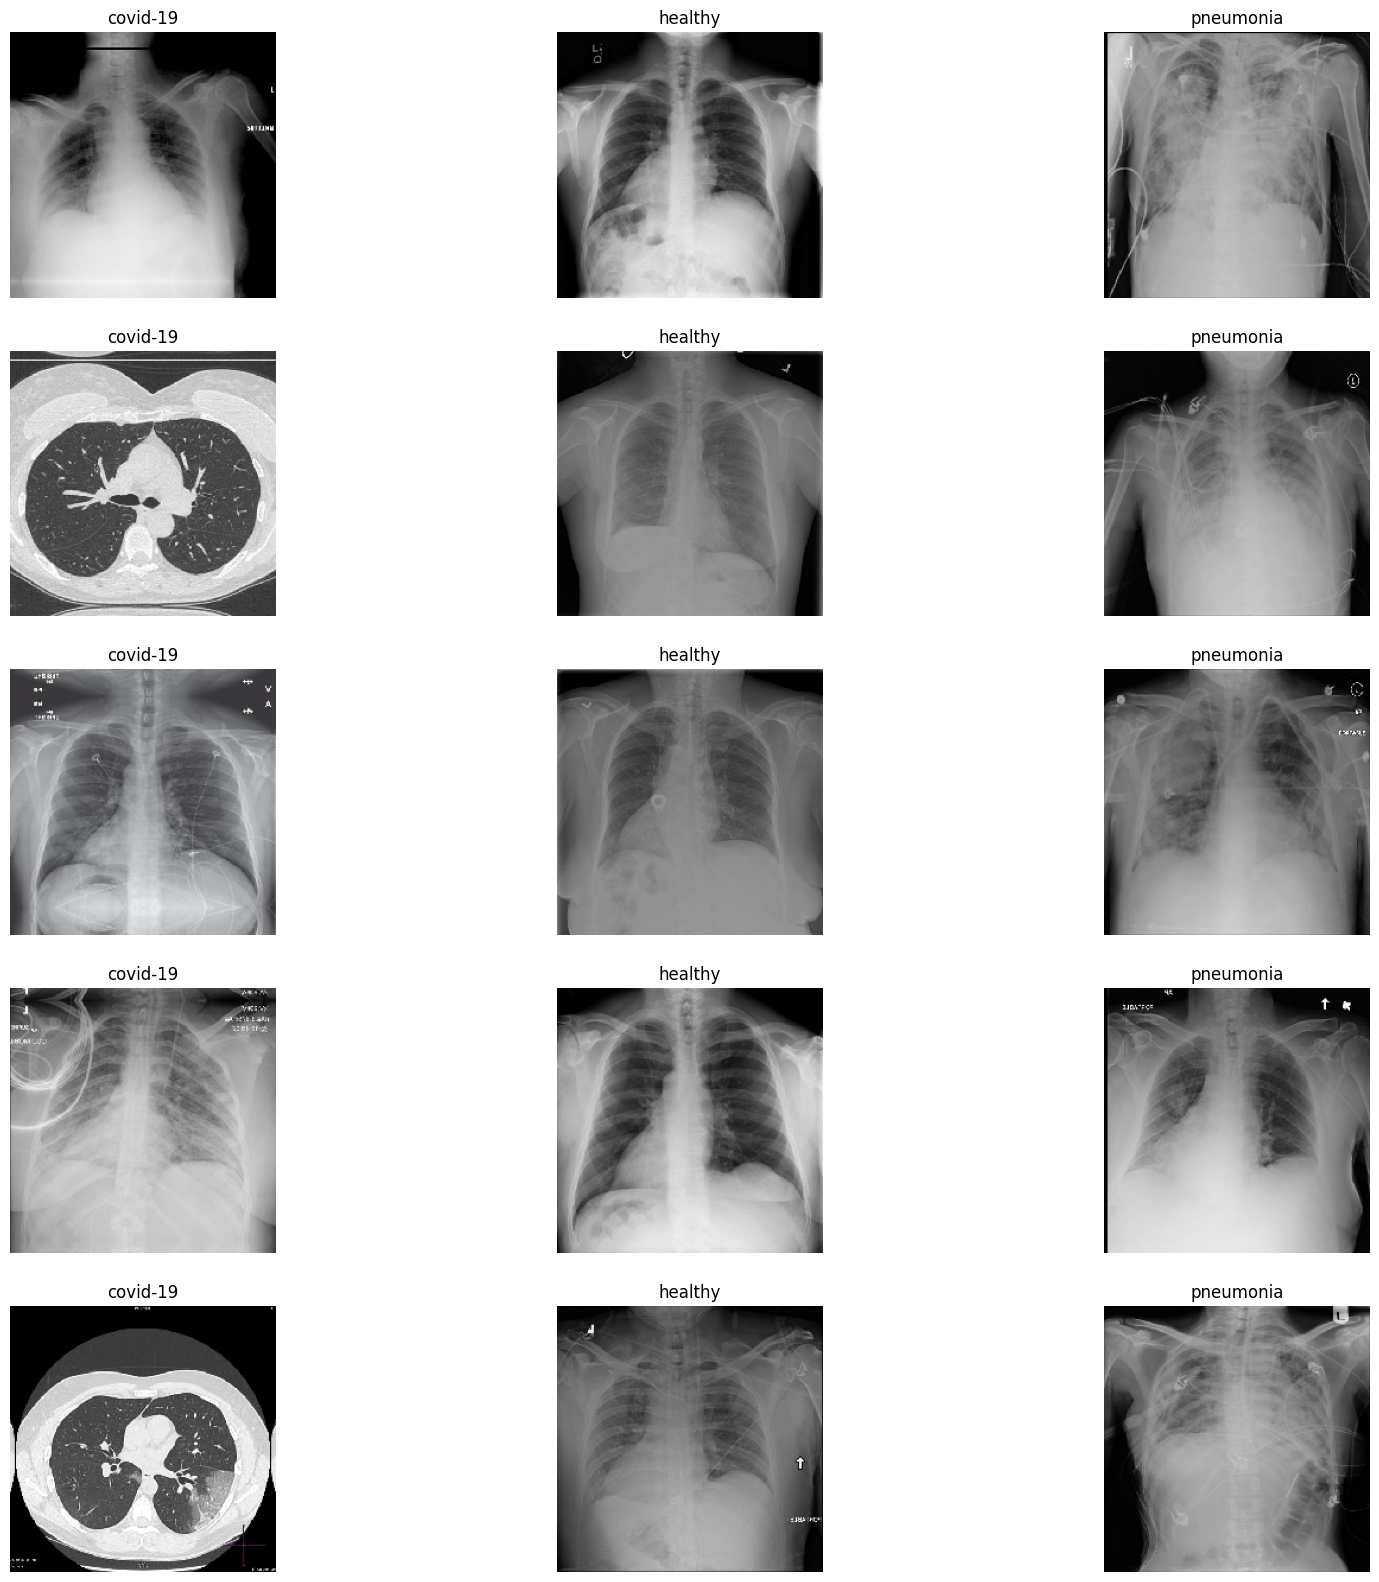

In [7]:

# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Create a dictionary to store images for each class
class_images = {class_name: [] for class_name in class_names}

# Loop over the samples until 5 images per class are found
while True:
    images, labels = next(train_gen)
    for j in range(len(labels)):
        class_name = class_names[np.argmax(labels[j])]
        if len(class_images[class_name]) < 5:
            class_images[class_name].append(images[j])

    # Stop once 5 images per class are found
    if all(len(images) == 5 for images in class_images.values()):
        break

# Create a figure with 5 rows and N columns
fig, axs = plt.subplots(5, num_classes, figsize=(20, 20))

# Loop over the classes and plot the corresponding images
for i in range(num_classes):
    for j in range(5):
        axs[j, i].imshow(class_images[class_names[i]][j]/255)
        axs[j, i].set_title(class_names[i])
        axs[j, i].axis('off')

plt.show()

In [8]:
from tensorflow.keras.applications import VGG16  # Change from VGG19 to VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
import matplotlib.pyplot as plt

# Load pre-trained VGG16 model without the top layer (include_top=False)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in VGG16 to avoid training them during initial training
for layer in vgg16.layers:
    layer.trainable = False

# Add custom top layers (fully connected layers) on top of VGG16
x = Flatten()(vgg16.output)  # Flatten the output of VGG16
x = Dense(1024, activation='relu')(x)  # Add a dense layer with 1024 units and ReLU activation
x = Dense(3, activation='softmax')(x)  # Output layer with 4 classes (covid, healthy, pneumonia, other)

# Create the final model
model = Model(inputs=vgg16.input, outputs=x)

# Compile the model (for training purposes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Optionally, visualize the model architecture (Uncomment the following lines if needed)
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file='vgg16_model.png')
# plt.imshow(plt.imread('vgg16_model.png'))  # Uncomment to display the image


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras.applications import VGG16  # Change from VGG19 to VGG16
from tensorflow.keras.models import Model

# Create new model with custom top layer (replace vgg19 with vgg16)
model = Model(inputs=vgg16.input, outputs=x)  # Use vgg16 instead of vgg19

# Compile model with categorical crossentropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model for exactly 20 epochs
history = model.fit(
    train_gen,                      # Training data generator
    validation_data=valid_gen,      # Validation data generator
    epochs=20,                      # Train for exactly 20 epochs
    verbose=1                       # Print training progress
)


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 51s 143ms/step - accuracy: 0.7078 - loss: 20.0391 - val_accuracy: 0.7470 - val_loss: 0.7781
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - accuracy: 0.8482 - loss: 0.3900 - val_accuracy: 0.8217 - val_loss: 0.4357
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.8918 - loss: 0.2597 - val_accuracy: 0.8081 - val_loss: 0.4686
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.9058 - loss: 0.2303 - val_accuracy: 0.8506 - val_loss: 0.4442
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 36s 123ms/step - accuracy: 0.9217 - loss: 0.2037 - val_accuracy: 0.8438 - val_loss: 0.4497
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 37s 126ms/step - accuracy: 0.9302 - loss: 0.1851 - val_accuracy: 0.8353 - val_loss: 0.4861
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.9450 - loss: 0.1548 - val_accuracy: 0.8217 - val_loss: 0.5404
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 36s 121ms/step - accuracy: 0.9374 - loss: 

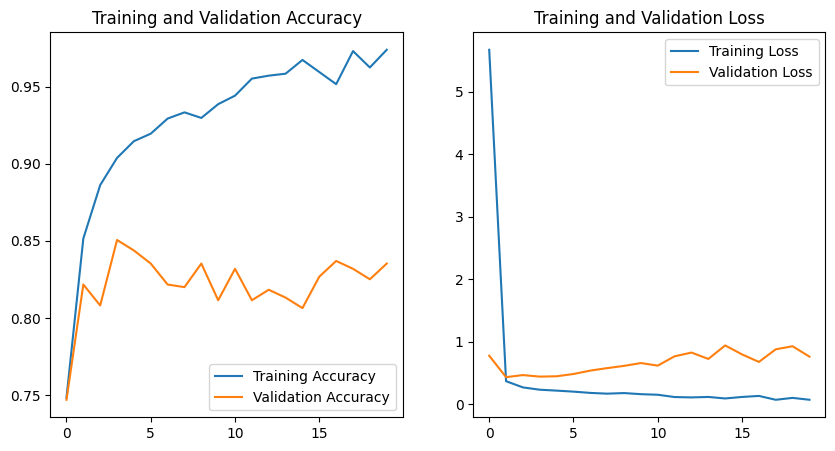

In [10]:
# Plot the training and validation accuracy over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) #Change with the number of epochs

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# Save the trained model to a file
model.save('VGG16_Model.h5', save_format='h5')

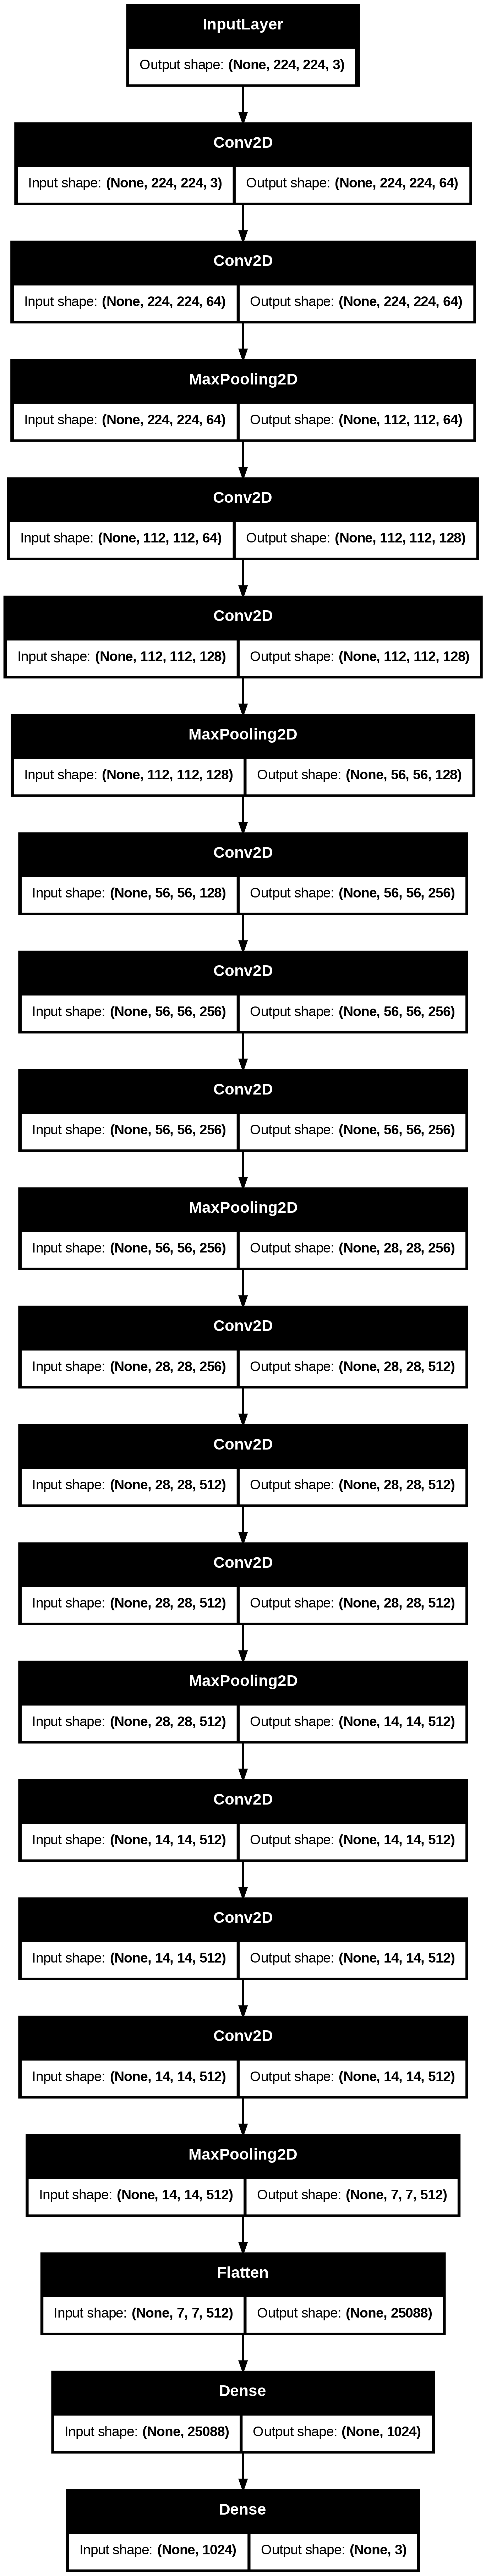

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [13]:
def get_predictions(model, test_data):
    preds = model.predict_generator(test_data)
    y_pred = np.argmax(preds, axis=1)
    return y_pred

In [14]:
def plot_confusion_matrix(model_name,true_labels, pred_labels):
    cm_array = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues')

    # Add labels, title, and ticks to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix of ' + str(model_name))
    plt.xticks(ticks=[0, 1, 2], labels=classes)
    plt.yticks(ticks=[0, 1, 2], labels=classes)
    plt.show()
    return cm_array

In [15]:
def roundup(input_value):
    return round(input_value * 100, 2)

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
true_labels = test_gen.classes

In [17]:
VGG = keras.models.load_model('VGG16_Model.h5')

In [18]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the model
VGG = load_model('/content/VGG16_Model.h5')

# Recompile the model (with the appropriate loss, optimizer, and metrics)
VGG.compile(loss='categorical_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy'])



In [19]:
# Set the batch size in the test generator to a smaller value
test_batch_size = 8  # Set a smaller batch size
test_gen = test_augmentor.flow_from_dataframe(
    test_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size  # smaller batch size here
)

# Now evaluate the model
VGG_Accuracy = VGG.evaluate(test_gen)
print("Test Accuracy:", VGG_Accuracy[1])


Found 589 validated image filenames belonging to 3 classes.
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.8218 - loss: 0.7331
Test Accuracy: 0.8302206993103027


In [20]:
import numpy as np

def get_predictions(model, test_data):
    # Use model.predict() instead of predict_generator
    preds = model.predict(test_data)
    # Get the index of the highest predicted class (argmax)
    y_pred = np.argmax(preds, axis=1)
    return y_pred


In [21]:
# Get predictions for the test set
VGG_preds = get_predictions(VGG, test_gen)



74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step


In [22]:
VGG_CR = classification_report(true_labels, VGG_preds, target_names= classes)

In [ ]:
print("----------------------------------------------------------------")
print("Classification Report of VGG")
print("----------------------------------------------------------------")
print(VGG_CR)
print("----------------------------------------------------------------")


----------------------------------------------------------------
Classification Report of VGG
----------------------------------------------------------------
              precision    recall  f1-score   support

    covid-19       1.00      0.75      0.86        20
     healthy       0.77      0.84      0.80       197
   pneumonia       0.90      0.87      0.89       372

    accuracy                           0.86       589
   macro avg       0.89      0.82      0.85       589
weighted avg       0.86      0.86      0.86       589

----------------------------------------------------------------


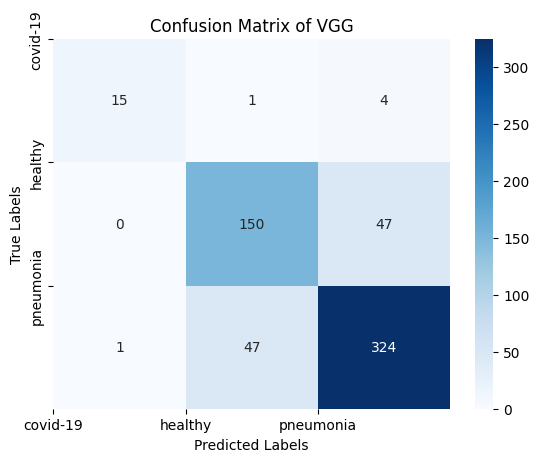

In [23]:
VGG_CM = plot_confusion_matrix('VGG',true_labels, VGG_preds)

[0 1 2]
